In [1]:
import numpy as np
import torch
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_fashion_mnist(data_path):
    cifar_path = os.path.join(data_path, 'fashion_mnist')

    x_train = np.load(os.path.join(cifar_path, 'fashion_train_x.npy'))
    y_train = np.load(os.path.join(cifar_path, 'fashion_train_y.npy'))
    x_test = np.load(os.path.join(cifar_path, 'fashion_test_x.npy'))
    y_test = np.load(os.path.join(cifar_path, 'fashion_test_y.npy'))

    # Flatten X
    x_train = x_train.reshape(len(x_train), -1)
    x_test = x_test.reshape(len(x_test), -1)

    return x_train, y_train, x_test, y_test

def load_mnist(data_path):
    tt = pd.read_csv(data_path)
    tt = np.array(tt)
    
    x_train = tt[:, 1:]
    y_train = tt[:, 1]
    
    return x_train, y_train

In [3]:
x_train, y_train = load_mnist("./data/mnist/mnist_train.csv")
#x_train, y_train, x_test, y_test =load_fashion_mnist("./data")

In [4]:
input_dim = x_train.shape[1]
total_data = x_train.shape[0]
batch = 100
hidden = 256
classes = max(y_train)
epochs = 10
k = 5
noise_input = 128
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()
#device = torch.device("cpu")

True

In [5]:
G = nn.Sequential(
    nn.Linear(noise_input, hidden),
    nn.ReLU(),
    nn.Linear(hidden, input_dim),
).to(device)
D = nn.Sequential(nn.Linear(input_dim, hidden),
                  nn.LeakyReLU(),
                 nn.Linear(hidden,1),
                 nn.Sigmoid()).to(device)

In [364]:
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [365]:
criterion = nn.BCELoss()

In [366]:
for epoch in range(epochs + 1):
    for iteration in range(total_data // batch):
        z = np.random.normal(size = (batch, noise_input))
        z = torch.Tensor(z).to(device)

        seed = np.random.choice(total_data, batch)
        x_batch = torch.Tensor(x_train[seed,:]).to(device)
        y_batch = torch.ones(batch,1).to(device)
        y_noise = torch.zeros(batch,1).to(device)
        for i in range(k):
            G_out = G(z)
            D_loss = criterion(D(x_batch), y_batch) + criterion(D(G(z)), y_noise)
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

        G_loss = criterion(D(G(z)), y_batch)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
    if epoch % 1 == 0:
        print(f"G loss : {G_loss}  | D loss  :  {D_loss}")

G loss : 11.455000877380371  | D loss  :  0.09698876738548279
G loss : 50.4973258972168  | D loss  :  0.27683505415916443
G loss : 48.60011672973633  | D loss  :  1.19209286886246e-09
G loss : 42.07880783081055  | D loss  :  4.6155761083355173e-05
G loss : 40.66522979736328  | D loss  :  1.4278931617736816
G loss : 30.78582191467285  | D loss  :  0.2763102054595947
G loss : 29.763437271118164  | D loss  :  0.2763102054595947
G loss : 30.4794979095459  | D loss  :  0.1433294713497162
G loss : 30.36306381225586  | D loss  :  0.0
G loss : 32.11591720581055  | D loss  :  1.6578612327575684
G loss : 27.938701629638672  | D loss  :  1.105240821838379


In [367]:
noise = np.random.normal(size = (10, noise_input))
noise = torch.Tensor(noise)
noise.requires_grad_(False)
img = G(noise)

In [368]:
img = img.reshape(10,28,28)

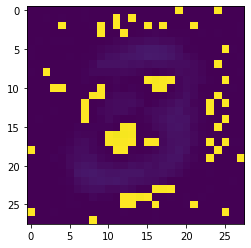

In [383]:
i = np.random.choice(10,1)
image = img[i]
image = image.reshape(28,28)
image = np.array(image.detach(), dtype = np.uint8)
plt.imshow(image)

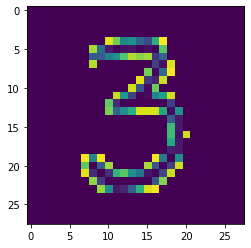

In [352]:
test = np.array(x_train[50] * 255, dtype= np.uint8).reshape(28,28)
plt.imshow(test)